## Imports

In [1]:
import os
import glob
import cv2
# import random
import numpy as np 
import pandas as pd
from  PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import math
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay,auc, roc_curve, roc_auc_score
from itertools import cycle
import joblib
from sklearn.ensemble import VotingClassifier
import csv
warnings.filterwarnings("ignore")

## Functions

In [7]:
def get_images_labels(data_path, resize=False):
    """Reads the images from the data path and returns the images and labels as numpy arrays

    Args:
        data_path (str): The path to the images
        resize (bool): Whether to resize the images or not

    Returns:
        images: np.array: The images as a numpy array
        labels: np.array: The labels as a numpy array
    """
    images = []
    labels = []
    for image_path in sorted(glob.glob(os.path.join(data_path, "*.jpg"))):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if resize:
            image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
        images.append(image)
        labels.append(image_path.split("\\")[-1])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def visualise_images(images, labels):
    """
    Visualise the images in a grid format
    Args:
        images (np.array): Images as a numpy array
        labels (np.array): Labels as a numpy array
    
    Returns:
        None
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

def hair_removal(image: np.ndarray, structuring_element_size: int = 15) -> np.ndarray:
    """
    Remove hair-like structures from an image using morphological operations and inpainting.
    
    Args:
        image (np.ndarray): Input color image
        structuring_element_size (int): Size of the structuring elements for morphological operations
    
    Returns:
        np.ndarray: Image with hair-like structures removed
    """
    # Convert the original image to grayscale if it has > 1 channel
    if len(image.shape) == 3:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = image

    # Create structuring elements for morphological filtering
    plus_shaped_se = cv2.getStructuringElement(1, (structuring_element_size, structuring_element_size))
    x_shaped_se = np.array(list(reversed(list(zip(*np.eye(structuring_element_size)))))) + np.eye(structuring_element_size)
    x_shaped_se[int(structuring_element_size/2), int(structuring_element_size/2)] = 1

    # Perform blackHat filtering on the grayscale image to find hair-like structures
    blackhat_plus = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, plus_shaped_se)
    blackhat_x = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, x_shaped_se.astype(np.uint8))
    combined_blackhat = blackhat_plus + blackhat_x

    # Create a binary mask of detected structures
    _, binary_mask = cv2.threshold(combined_blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint the original image using the binary mask
    inpainted_image = cv2.inpaint(image, binary_mask, 1, cv2.INPAINT_TELEA)

    return inpainted_image
    
def crop_img(img, threshold=100):
    """
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.
    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int)    : Value to split the diagonal into image and frame.
    Return:
    - The coordinates of the rectangle and the cropped image.
    """
    # Get the image dimensions
    h, w = img.shape[:2]
    cd = math.gcd(h, w)  # Greatest Common Divider

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, int(h/cd))], [i for i in range(h - int(h/cd), 0, -int(h/cd))])
    x_coords = ([i for i in range(0, w, int(w/cd))], [i for i in range(0, w, int(w/cd))])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i])-idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i])-idx]
                break

    # Set the coordinates to crop the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    img_new = img[y1:y2, x1:x2, :]

    if img_new.shape[0] == 0 or img_new.shape[1] == 0:
      img_new = img 
    
    return img_new 

def normalize_colors_shades_of_gray(image: np.ndarray, norm_degree: int = 6, gamma_correction: float = None):
    """
    Normalize the colors of an image using the Shades of Gray algorithm with optional gamma correction.

    Parameters:
    - image (np.ndarray): The original image array in the format (height, width, channels).
    - norm_degree (int): The degree of the norm used for normalization, typically 6 as per the reference paper.
    - gamma_correction (float): Gamma correction value, typically 2.2 as per the reference paper, if None, no gamma correction is applied.

    Returns:
    - np.ndarray: The color-normalized image.
    """
    original_dtype = image.dtype  # Save original data type of image for later conversion

    if gamma_correction is not None:
        # Apply gamma correction
        image = image.astype('uint8')  # Convert image to uint8 for processing
        gamma_lookup_table = np.array([255 * (i / 255) ** (1 / gamma_correction) for i in range(256)], dtype='uint8').reshape(256, 1)
        image = cv2.LUT(image, gamma_lookup_table)  # Apply the lookup table

    # Convert image to float32 for normalization calculations
    image = image.astype('float32')

    # Calculate powers of the image's color channels and the mean across spatial dimensions
    channel_powers = np.power(image, norm_degree)
    mean_powers = np.power(np.mean(channel_powers, axis=(0, 1)), 1 / norm_degree)

    # Normalize the channel vectors
    norm_factor = np.sqrt(np.sum(np.square(mean_powers)))
    normalization_vector = mean_powers / norm_factor
    normalization_vector = 1 / (normalization_vector * np.sqrt(3))

    # Apply the normalization vector to the original image
    normalized_image = image * normalization_vector

    # Clip values to maintain image integrity and convert back to original data type
    normalized_image = np.clip(normalized_image, 0, 255).astype(original_dtype)

    return normalized_image

def enhance_structures(image):
    """Enhance the structures in an image using the unsharp masking technique. It is used to enhance the edges and details in an image. 
    Args:
        image (np.array): Image as a numpy array

    Returns:
        image: np.array: The image with the hair removed
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    image[binary == 255] = 255
    return image

def glcm_feature_extractor(image):
    """GLCM is a 2D matrix that is used to capture the spatial relationship between pixels in an image. It is used to capture the texture information of an image.
        It first gets the matrix of co-occurrence of pixel intensity pairs at a distance d = 1 [left, right, up, down] and angle theta = 0 (which is horizontal i.e 
        left to right). Then it calculates different statistics {contrast, correlation, energy and homogeneity} from the GLCM. It is calculated for different 
        distances and angles. 

    Args:
        image: Image as a numpy array

    Returns:
        features: List: A list containing the GLCM features
    """
    img = image
    GLCM = graycomatrix(img, [1], [0])       
    GLCM_Energy = graycoprops(GLCM, 'energy')[0]
    GLCM_corr = graycoprops(GLCM, 'correlation')[0]   
    GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]     
    GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]    
    GLCM_contr = graycoprops(GLCM, 'contrast')[0]


    GLCM2 = graycomatrix(img, [3], [0])       
    GLCM_Energy2 = graycoprops(GLCM2, 'energy')[0]
    GLCM_corr2 = graycoprops(GLCM2, 'correlation')[0]      
    GLCM_diss2 = graycoprops(GLCM2, 'dissimilarity')[0]       
    GLCM_hom2 = graycoprops(GLCM2, 'homogeneity')[0]      
    GLCM_contr2 = graycoprops(GLCM2, 'contrast')[0]

    GLCM3 = graycomatrix(img, [5], [0])       
    GLCM_Energy3 = graycoprops(GLCM3, 'energy')[0]
    GLCM_corr3 = graycoprops(GLCM3, 'correlation')[0]    
    GLCM_diss3 = graycoprops(GLCM3, 'dissimilarity')[0]     
    GLCM_hom3 = graycoprops(GLCM3, 'homogeneity')[0]  
    GLCM_contr3 = graycoprops(GLCM3, 'contrast')[0]


    GLCM4 = graycomatrix(img, [0], [np.pi/4])       
    GLCM_Energy4 = graycoprops(GLCM4, 'energy')[0]
    GLCM_corr4 = graycoprops(GLCM4, 'correlation')[0]    
    GLCM_diss4 = graycoprops(GLCM4, 'dissimilarity')[0]      
    GLCM_hom4 = graycoprops(GLCM4, 'homogeneity')[0]     
    GLCM_contr4 = graycoprops(GLCM4, 'contrast')[0]
    
    GLCM5 = graycomatrix(img, [0], [np.pi/2])       
    GLCM_Energy5 = graycoprops(GLCM5, 'energy')[0]
    GLCM_corr5 = graycoprops(GLCM5, 'correlation')[0]       
    GLCM_diss5 = graycoprops(GLCM5, 'dissimilarity')[0]      
    GLCM_hom5 = graycoprops(GLCM5, 'homogeneity')[0]     
    GLCM_contr5 = graycoprops(GLCM5, 'contrast')[0]

    features = [GLCM_Energy, GLCM_corr, GLCM_diss, GLCM_hom, GLCM_contr, 
                GLCM_Energy2, GLCM_corr2, GLCM_diss2, GLCM_hom2, GLCM_contr2, 
                GLCM_Energy3, GLCM_corr3, GLCM_diss3, GLCM_hom3, GLCM_contr3, 
                GLCM_Energy4, GLCM_corr4, GLCM_diss4, GLCM_hom4, GLCM_contr4, 
                GLCM_Energy5, GLCM_corr5, GLCM_diss5, GLCM_hom5, GLCM_contr5]
    return features

def lbp_feature_extractor(image, radius=1, points=8):
    """Takes the image, calculate the local binary pattern and then the histogram of the LBP using N points circularity and a radius (distance) of D from a 
        center pixel and does this for all pixels in the image to get the LBP image. The lbp is converted to a 1D array and then a histogram is 
        calculated that represents the distribution of the LBP values. It captures the local texture information (binary (sign)) of the image. It 
        uses the 'uniform' method so that it is grayscale and rotation invariant. 
        We could use different radius and number of points to be invariant to different scales.
        Gridding the image is beneficial if the image is large and the object is large. But for e.g small lesions, it is ok to use the whole image.
    Args:
        image (np.array): Image as a numpy array
        radius (int): The radius of the circle that is used to sample the points
        points (int): The number of points to sample on the circle

    Returns:
        np.array: The LBP histogram features
    """
    img = image
    lbp = local_binary_pattern(img, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2)) 
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return np.array(hist)
    
def color_moments(img: np.ndarray) -> np.ndarray:
    """Extract Color Moments of an image.
    Args:
        img: np.ndarray, RGB image
    Returns:
        np.ndarray: Contains the 4 central color moments for each color channel
    """
    channels = cv2.split(img)
    color_feature = []

    for channel in channels:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(abs(channel - mean) ** 3) ** (1 / 3)
        variance = std ** 2

        color_feature.extend([mean, std, skewness, variance])

    return np.array(color_feature).reshape(1, -1)

def extract_color_histogram(img: np.ndarray, n_bins: int = 256) -> np.ndarray:
    """Extract Color Histogram of an image.
    Args:
        img: np.ndarray, RGB image
        n_bins: int, Number of bins for the histogram
    Returns:
        np.ndarray: Contains concatenated histogram features of the image in RGB, HSV, and LAB color spaces
    """
    color_spaces = [
        (img, "RGB"),
        (cv2.cvtColor(img, cv2.COLOR_RGB2HSV), "HSV"),
        (cv2.cvtColor(img, cv2.COLOR_RGB2LAB), "LAB")
    ]
    histogram_features = []

    for color_space_img, color_space_name in color_spaces:
        channels = cv2.split(color_space_img)
        for channel in channels:
            hist = cv2.calcHist([channel], [0], None, [n_bins], [1, 256])
            hist = hist / hist.sum()
            histogram_features.extend(hist.flatten())

    return np.array(histogram_features).reshape(1, -1)

def binarize_and_make_mask(image):
    """Binarize the image and create a mask of the image. It is used to create a binary mask of the image. It is used to segment the image. 
    Args:
        image (np.array): Image as a numpy array

    Returns:
        image: np.array: The binary mask of the image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

## Data Pre-Processing

1. Hair Removal
2. ROI
3. Color normalization

In [3]:
TRAIN_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/3_class_train/*', "*.jpg")))
VAL_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/3_class_val/*', "*.jpg")))
print(f"Number of training images: {len(TRAIN_IMAGES_PATH)}")
print(f"Number of validation images: {len(VAL_IMAGES_PATH)}")

Number of training images: 5082
Number of validation images: 1270


In [4]:
# Load the images and labels
# train_images, train_labels = get_images_labels('../../dataset/3_class_train/*', resize=True)
test_images, test_labels = get_images_labels('../../dataset/3_class_val/*', resize=True)


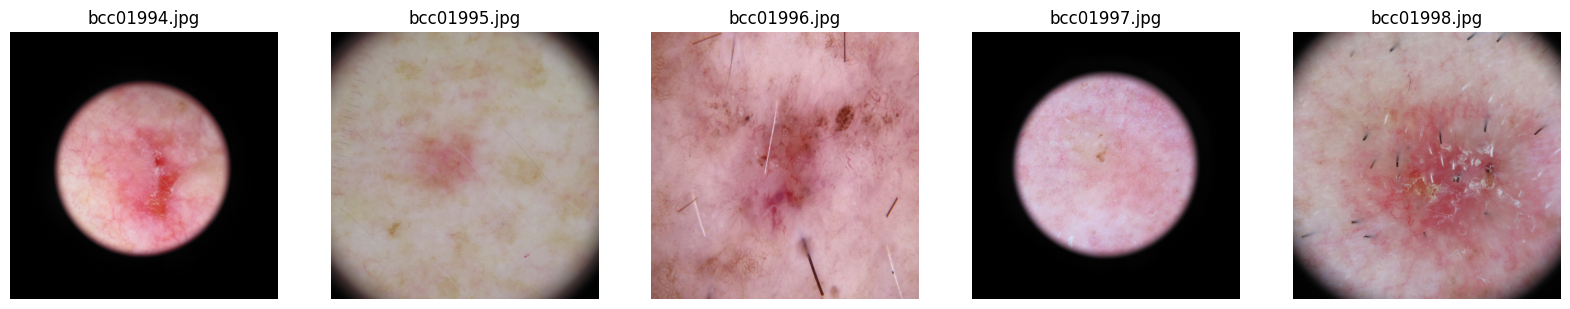

In [5]:
# Visualise the images
visualise_images(test_images[:5], test_labels[:5])

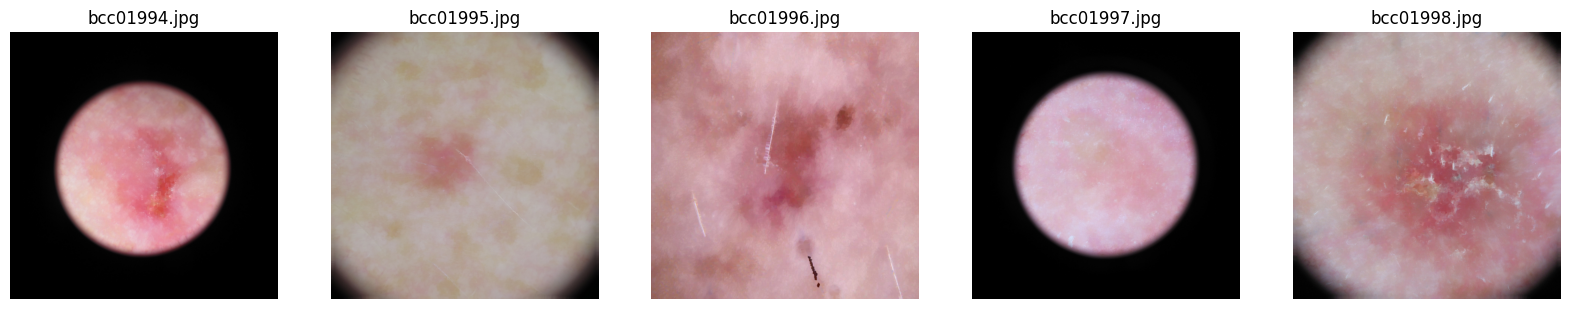

In [6]:
# hair removal
test_images_hair_removal = [hair_removal(image) for image in test_images[0:5]]
visualise_images(test_images_hair_removal[:5], test_labels[0:5])

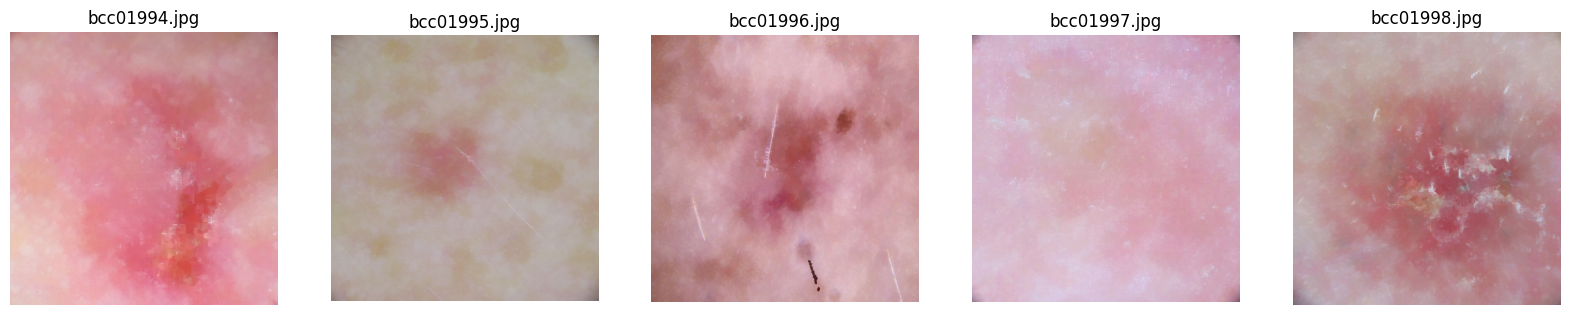

In [7]:
cropped_images = [crop_img(image) for image in test_images_hair_removal[:5]]
visualise_images(cropped_images, test_labels[:5])

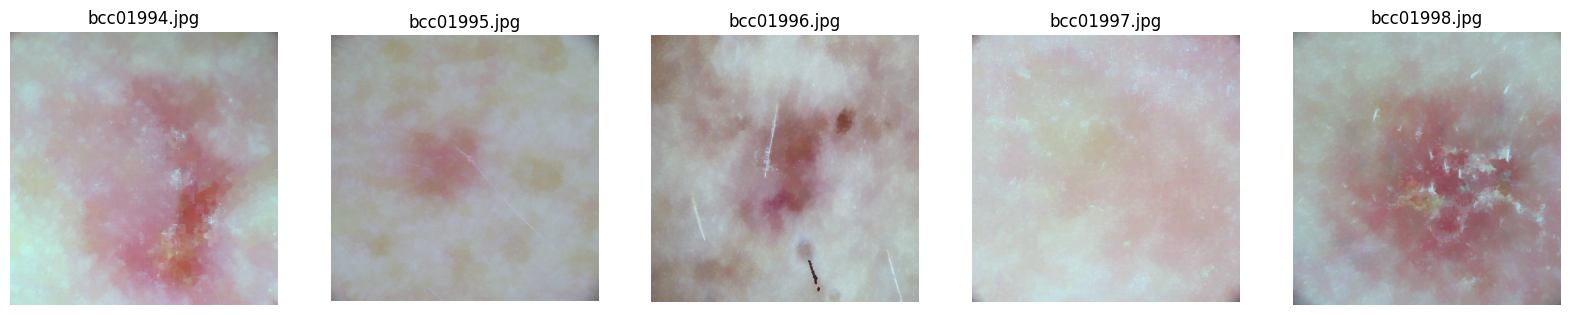

In [8]:
norm_images = [normalize_colors_shades_of_gray(image) for image in cropped_images]
visualise_images(norm_images, test_labels[:5])

In [20]:
# save pre-processed images in appropriate folders
# for image_path in TRAIN_IMAGES_PATH:
#     directory = '/'.join(image_path.replace("\\", "/").split('/')[-2:])
#     save_path = os.path.join('../../dataset/preprocessed_3_class_train', directory)
#     if os.path.exists(save_path):
#         continue
#     else:
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.resize(image, (500, 500))
#         hair_removed = hair_removal(image)
#         cropped_image = crop_img(hair_removed)
#         norm_image = normalize_colors_shades_of_gray(cropped_image)
#         pil_image = Image.fromarray(norm_image)
#         pil_image.save(save_path)


In [21]:
# save pre-processed images in appropriate folders
# for image_path in VAL_IMAGES_PATH:
#     directory = '/'.join(image_path.replace("\\", "/").split('/')[-2:])
#     save_path = os.path.join('../../dataset/preprocessed_3_class_val', directory)
#     if os.path.exists(save_path):
#         continue
#     else:
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.resize(image, (500, 500))
#         hair_removed = hair_removal(image)
#         cropped_image = crop_img(hair_removed)
#         norm_image = normalize_colors_shades_of_gray(cropped_image)
#         pil_image = Image.fromarray(norm_image)
#         pil_image.save(save_path)

## Feature Extraction

1. Color Moments: Mean, Std, Variance, Skewness, 
2. Color Hist in *HSV, LAB, RGB
3. Texture: LBP and GLCM


In [8]:
# # Load the preprocessed images
PREPROCESSED_TRAIN_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/preprocessed_3_class_train/*', "*.jpg")))
PREPROCESSED_VAL_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/preprocessed_3_class_val/*', "*.jpg")))
print(f"Number of training images: {len(PREPROCESSED_TRAIN_IMAGES_PATH)}")
print(f"Number of validation images: {len(PREPROCESSED_VAL_IMAGES_PATH)}")

Number of training images: 5082
Number of validation images: 1270


In [9]:
# Load the image labels
train_labels = [image_path.split('\\')[-2] for image_path in PREPROCESSED_TRAIN_IMAGES_PATH]
val_labels = [image_path.split('\\')[-2] for image_path in PREPROCESSED_VAL_IMAGES_PATH]
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")

# labels encoding
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
val_labels_encoded = le.transform(val_labels)

print(pd.Series(train_labels).value_counts())


classes = np.array([0, 1, 2])
samples_per_class = [1993, 2713, 376]

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.repeat(classes, samples_per_class))
class_weights_dict = dict(zip(classes, class_weights))

# Normalize class weights so that they sum up to 1
class_weights_normalized = class_weights / np.sum(class_weights)
class_weights_dict = dict(zip(classes, class_weights_normalized))

print(class_weights_dict)

Number of training labels: 5082
Number of validation labels: 1270
mel    2713
bcc    1993
scc     376
dtype: int64
{0: 0.14214352052159387, 1: 0.10442021245836217, 2: 0.753436267020044}


In [7]:
# compute the training features
color_moments_train_features = []
color_histogram_train_features = []

for image_path in PREPROCESSED_TRAIN_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = enhance_structures(image)
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_train_features.append(moments)
    color_histogram_train_features.append(histogram)
color_moments_train_features = np.array(color_moments_train_features).reshape((5082, 12))
color_histogram_train_features = np.array(color_histogram_train_features).reshape((5082, 2304))

lbp_train_image_features = []
glcm_train_image_features = []

for image_path in PREPROCESSED_TRAIN_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = enhance_structures(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_5_8 = lbp_feature_extractor(image, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image, radius=10, points=16)
    glcm = glcm_feature_extractor(image)
    lbp_train_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_train_image_features.append(glcm)
lbp_train_image_features = np.array(lbp_train_image_features)
glcm_train_image_features = np.array(glcm_train_image_features).reshape((5082, 25))   

In [8]:
# compute the validation features
color_moments_val_features = []
color_histogram_val_features = []

for image_path in PREPROCESSED_VAL_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = enhance_structures(image)
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_val_features.append(moments)
    color_histogram_val_features.append(histogram)
color_moments_val_features = np.array(color_moments_val_features).reshape((1270, 12))
color_histogram_val_features = np.array(color_histogram_val_features).reshape((1270, 2304))


lbp_val_image_features = []
glcm_val_image_features = []

for image_path in PREPROCESSED_VAL_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = enhance_structures(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_5_8 = lbp_feature_extractor(image, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image, radius=10, points=16)
    glcm = glcm_feature_extractor(image)
    lbp_val_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_val_image_features.append(glcm)
lbp_val_image_features = np.array(lbp_val_image_features)
glcm_val_image_features = np.array(glcm_val_image_features).reshape((1270, 25))

In [9]:
print(f"Train labels shape: {train_labels_encoded.shape}")
print(f"GLCM Train features shape: {glcm_train_image_features.shape}")
print(f"LBP Train features shape: {lbp_train_image_features.shape}")
print(f"Color Moments Train features shape: {color_moments_train_features.shape}")
print(f"Color Histogram Train features shape: {color_histogram_train_features.shape}")

print(f"GLCM Validation features shape: {glcm_val_image_features.shape}")
print(f"LBP Validation features shape: {lbp_val_image_features.shape}")
print(f"Color Moments Validation features shape: {color_moments_val_features.shape}")
print(f"Color Histogram Validation features shape: {color_histogram_val_features.shape}")

Train labels shape: (5082,)
GLCM Train features shape: (5082, 25)
LBP Train features shape: (5082, 56)
Color Moments Train features shape: (5082, 12)
Color Histogram Train features shape: (5082, 2304)
GLCM Validation features shape: (1270, 25)
LBP Validation features shape: (1270, 56)
Color Moments Validation features shape: (1270, 12)
Color Histogram Validation features shape: (1270, 2304)


In [10]:
# concatenate all features
# all_train_features = np.hstack((glcm_train_image_features, lbp_train_image_features, color_moments_train_features, color_histogram_train_features))
# all_val_features = np.hstack((glcm_val_image_features, lbp_val_image_features, color_moments_val_features, color_histogram_val_features))

# save all features
# np.save('../../dataset/preprocessed_3_class_train/all_train_features.npy', all_train_features)
# np.save('../../dataset/preprocessed_3_class_val/all_test_features.npy', all_val_features)

# # load all features
all_train_features = np.load('../../dataset/preprocessed_3_class_train/all_train_features.npy')
all_val_features = np.load('../../dataset/preprocessed_3_class_val/all_test_features.npy')

print(f"All Train features shape: {all_train_features.shape}")
print(f"All Validation features shape: {all_val_features.shape}")
# first 25 features are GLCM features, next 56 features are LBP features, next 12 features are color moments, and the last 2304 features are color histogram features

All Train features shape: (5082, 2397)
All Validation features shape: (1270, 2397)


# EDA

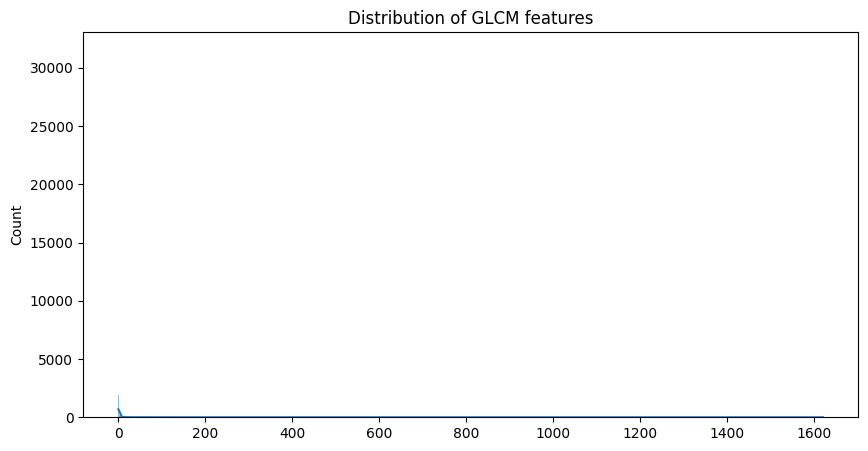

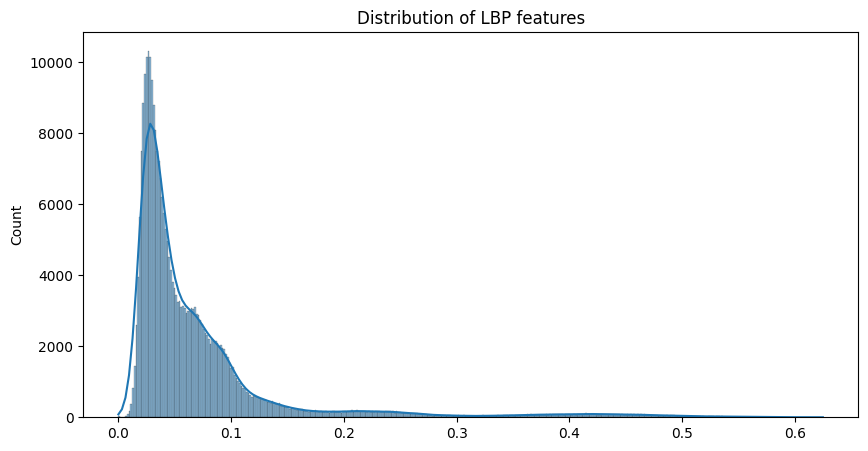

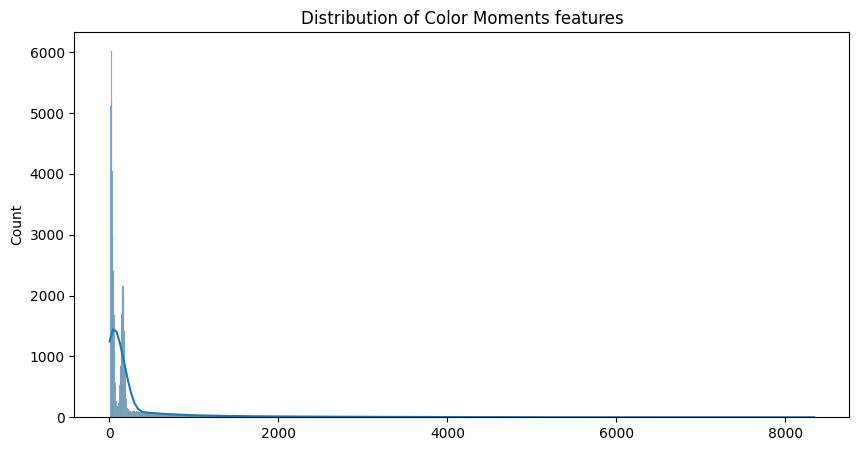

In [6]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

# MODEL Training

In [11]:
X_train, Y_train, x_val, y_val = all_train_features, train_labels_encoded, all_val_features, val_labels_encoded
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [8]:
# apply log transformation to the features
x_val_l = np.log1p(x_val)
X_train_l = np.log1p(X_train)

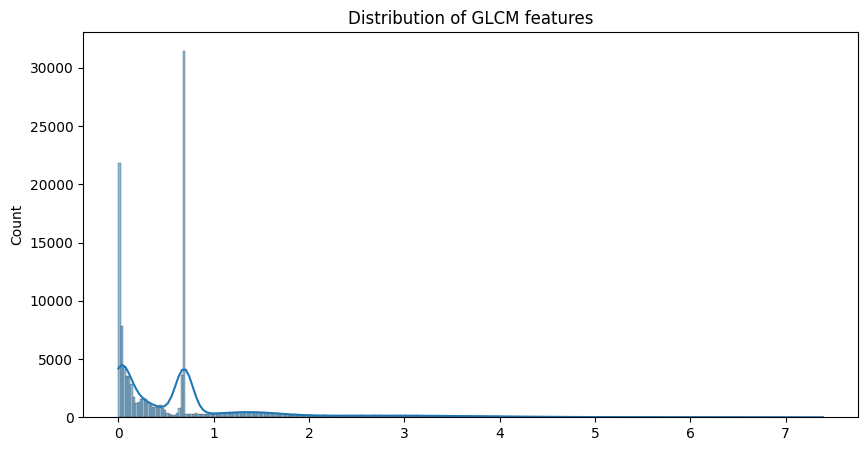

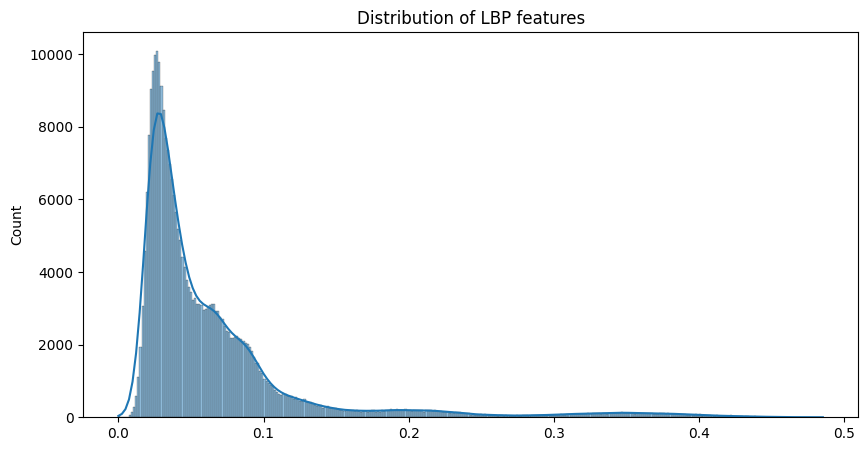

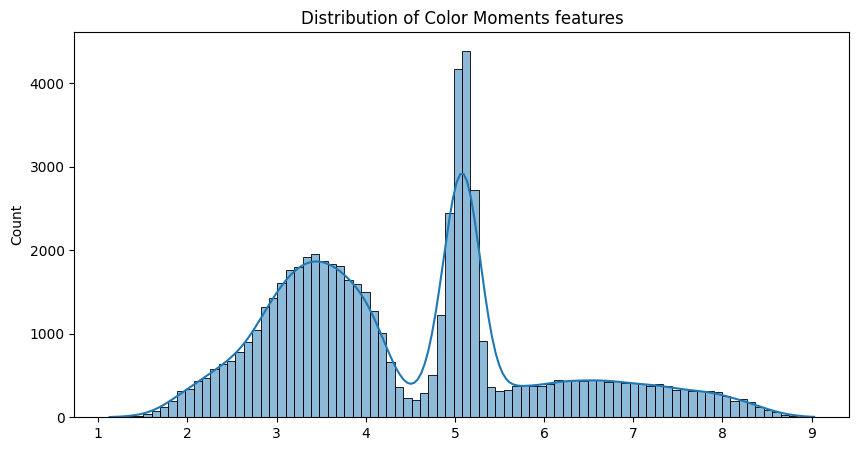

In [9]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

In [10]:
# apply min-max scaling to the features
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
x_val_s = scaler.transform(x_val_l)
X_train_s = scaler.transform(X_train_l)

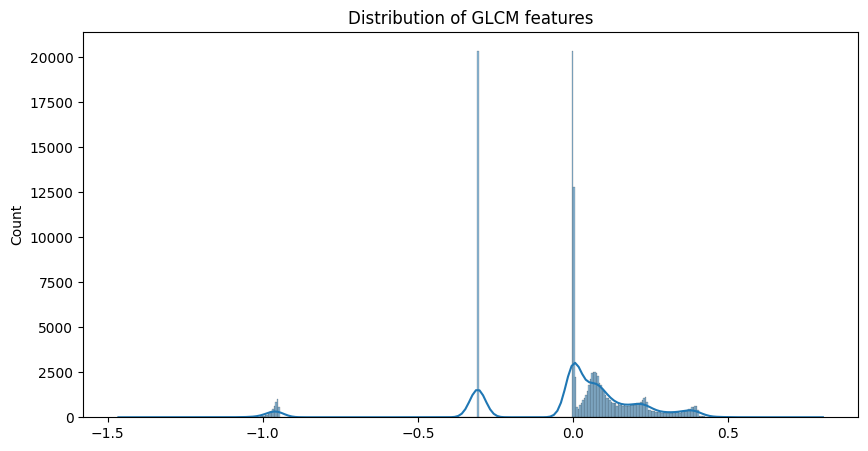

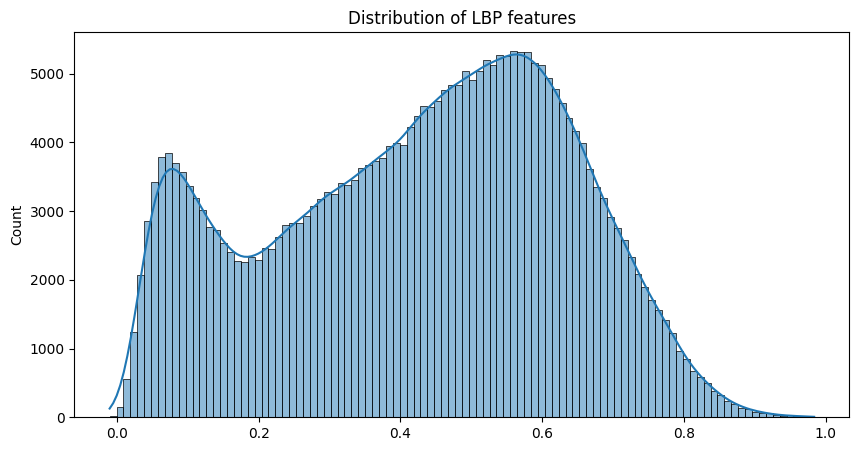

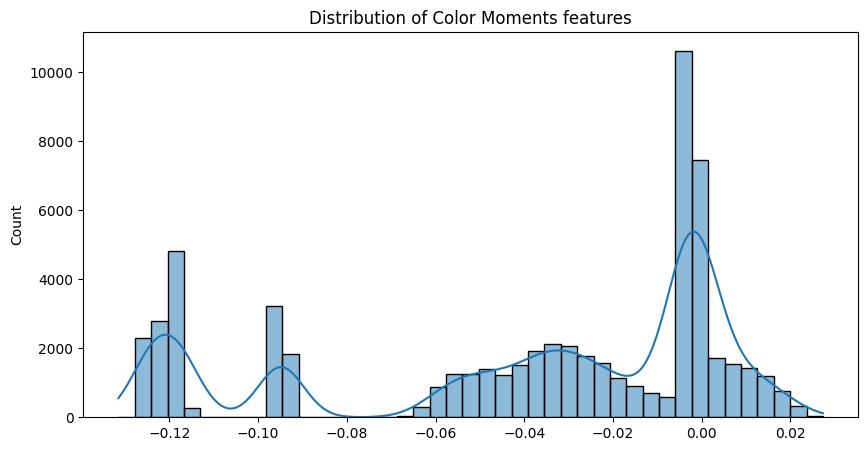

In [11]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

In [8]:
print("Train data shape: ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)
print("Validation data shape: ", x_val.shape)
print("Validation labels shape: ", y_val.shape)

Train data shape:  (4065, 2397)
Train labels shape:  (4065,)
Test data shape:  (1017, 2397)
Test labels shape:  (1017,)
Validation data shape:  (1270, 2397)
Validation labels shape:  (1270,)


## Model Training and Selection

In [12]:
model_list = [RandomForestClassifier(random_state=42, class_weight=class_weights_dict), KNeighborsClassifier(weights=class_weights_dict), 
              XGBClassifier(), lgb.LGBMClassifier(verbose=-1,class_weight=class_weights_dict),
              SVC(random_state=42,class_weight=class_weights_dict), CatBoostClassifier(logging_level='Silent', random_state=42, class_weights=class_weights_dict)]
model_names = ['Random Forest', 'KNN', 'XGBoost', 'LightGBM', 'SVM', 'CatBoost']

random_foreset_params = {'n_estimators': [200, 300], 'max_depth': [20, 30]}
svc_params = {'C': [ 1, 10], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
xgb_params = {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 30, 40, 50]}
lgbm_params = {'learning_rate': [0.05, 0.1, 0.2], 'boosting_type': ['gbdt', 'dart'], 'num_leaves': [31, 50, 100]}
catboost_params = {'iterations': [50, 100, 200, 300], 'depth': [4, 6, 8, 10]}

In [14]:
for model, model_name in zip(model_list, model_names):
    if model_name == 'Random Forest':
        param_grid = random_foreset_params
    elif model_name == 'SVM':
        param_grid = svc_params
    else:
        continue
    print("Hyperparameter tuning for {}".format(model_name))
    print("==============================================================================================")
    grid_search = GridSearchCV(model, param_grid, cv=2)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    print("Best Parameters for {}: {}".format(model_name, best_params))
    model = model.set_params(**best_params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_val_pred = model.predict(x_val)
    test_accuracy = metrics.accuracy_score(y_test, y_pred)
    val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy for {}: {:.3f}".format(model_name, val_accuracy))
    print("Kaapa Val Score for {}: {:.3f}".format(model_name, metrics.cohen_kappa_score(y_val, y_val_pred)))
    print("Test Accuracy for {}: {:.3f}".format(model_name, test_accuracy))
    print("Kappa Test Score for {}: {:.3f}".format(model_name, metrics.cohen_kappa_score(y_test, y_pred)))
    print("==============================================================================================")

Hyperparameter tuning for Random Forest
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Validation Accuracy for Random Forest: 0.798
Kaapa Val Score for Random Forest: 0.620
Test Accuracy for Random Forest: 0.795
Kappa Test Score for Random Forest: 0.623
Hyperparameter tuning for SVM
Best Parameters for SVM: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Validation Accuracy for SVM: 0.697
Kaapa Val Score for SVM: 0.409
Test Accuracy for SVM: 0.675
Kappa Test Score for SVM: 0.385


In [13]:
for model, model_name in zip(model_list, model_names): 
    if model_name == 'KNN':
        param_grid = knn_params
    elif model_name == 'XGBoost':
        param_grid = xgb_params
    elif model_name == 'LightGBM':
        param_grid = lgbm_params
    elif model_name == 'CatBoost':
        param_grid = catboost_params
    else:
        continue
    print("Hyperparameter tuning for {}".format(model_name))
    print("==============================================================================================")
    grid_search = GridSearchCV(model, param_grid, cv=2)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    print("Best Parameters for {}: {}".format(model_name, best_params))
    model = model.set_params(**best_params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_val_pred = model.predict(x_val)
    test_accuracy = metrics.accuracy_score(y_test, y_pred)
    val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy for {}: {:.3f}".format(model_name, val_accuracy))
    print("Kaapa Val Score for {}: {:.3f}".format(model_name, metrics.cohen_kappa_score(y_val, y_val_pred)))
    print("Test Accuracy for {}: {:.3f}".format(model_name, test_accuracy))
    print("Kappa Test Score for {}: {:.3f}".format(model_name, metrics.cohen_kappa_score(y_test, y_pred)))
    print("==============================================================================================")

Hyperparameter tuning for KNN
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Validation Accuracy for KNN: 0.752
Kaapa Val Score for KNN: 0.535
Test Accuracy for KNN: 0.735
Kappa Test Score for KNN: 0.508
Hyperparameter tuning for XGBoost
Best Parameters for XGBoost: {'max_depth': 30, 'n_estimators': 200}
Validation Accuracy for XGBoost: 0.829
Kaapa Val Score for XGBoost: 0.680
Test Accuracy for XGBoost: 0.818
Kappa Test Score for XGBoost: 0.665
Hyperparameter tuning for LightGBM
Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 100}
Validation Accuracy for LightGBM: 0.830
Kaapa Val Score for LightGBM: 0.682
Test Accuracy for LightGBM: 0.831
Kappa Test Score for LightGBM: 0.690
Hyperparameter tuning for CatBoost
Best Parameters for CatBoost: {'depth': 10, 'iterations': 300}
Validation Accuracy for CatBoost: 0.830
Kaapa Val Score for CatBoost: 0.685
Test Accuracy for CatBoost: 0.827
Kappa Test Score for

## Model Report for Each Classifier

In [9]:
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')
knn_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'KNN.pkl')
# joblib.dump(knn_model, model_path)

# Predict on the test data
val_prediction = knn_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.70      0.81      0.75       498
         mel       0.81      0.82      0.82       678
         scc       0.40      0.04      0.08        94

    accuracy                           0.76      1270
   macro avg       0.64      0.56      0.55      1270
weighted avg       0.74      0.76      0.74      1270

Kaapa Val Score: 0.5483578551007601


In [10]:
xgb_model = XGBClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight=class_weights_dict)
xgb_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'XGB.pkl')
# joblib.dump(xgb_model, model_path)

# Predict on the test data
val_prediction = xgb_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.78      0.89      0.83       498
         mel       0.88      0.89      0.89       678
         scc       0.61      0.12      0.20        94

    accuracy                           0.83      1270
   macro avg       0.76      0.63      0.64      1270
weighted avg       0.82      0.83      0.81      1270

Kaapa Val Score: 0.6883334568084161


In [11]:
# lightgbm model
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.2, num_leaves=50, class_weight=class_weights_dict, verbose=-1)
lgbm_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'LightGBM.pkl')
# joblib.dump(lgbm_model, model_path)

# Predict on the test data
val_prediction = lgbm_model.predict(x_val)
# Inverse le transform to get original label back.
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.80      0.89      0.84       498
         mel       0.89      0.89      0.89       678
         scc       0.73      0.29      0.41        94

    accuracy                           0.85      1270
   macro avg       0.81      0.69      0.72      1270
weighted avg       0.84      0.85      0.84      1270

Kaapa Val Score: 0.7164944913042284


In [12]:
svm_model = SVC(kernel='rbf', random_state=42, class_weight=class_weights_dict)
svm_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'SVM.pkl')
# joblib.dump(svm_model, model_path)

# Predict on the test data
val_prediction = svm_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.67      0.67      0.67       498
         mel       0.88      0.62      0.73       678
         scc       0.11      0.34      0.16        94

    accuracy                           0.62      1270
   macro avg       0.55      0.54      0.52      1270
weighted avg       0.74      0.62      0.66      1270

Kaapa Val Score: 0.3909574677601053


In [13]:
catboost_model = CatBoostClassifier(depth=10, iterations=300, logging_level='Silent', random_state=42, class_weights=class_weights_dict)
catboost_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'Catboost.pkl')
# joblib.dump(catboost_model, model_path)

# Predict on the test data
val_prediction = catboost_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.80      0.87      0.83       498
         mel       0.89      0.89      0.89       678
         scc       0.66      0.31      0.42        94

    accuracy                           0.84      1270
   macro avg       0.78      0.69      0.71      1270
weighted avg       0.83      0.84      0.83      1270

Kaapa Val Score: 0.7027954465545505


In [14]:
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42, class_weight=class_weights_dict)
random_foreset_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'RandomForest.pkl')
# joblib.dump(random_foreset_model, model_path)

# Predict on the test data
val_prediction = random_foreset_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

Classification report
              precision    recall  f1-score   support

         bcc       0.75      0.87      0.80       498
         mel       0.86      0.86      0.86       678
         scc       0.67      0.09      0.15        94

    accuracy                           0.81      1270
   macro avg       0.76      0.60      0.61      1270
weighted avg       0.80      0.81      0.79      1270

Kaapa Val Score: 0.6391074593350716


## Best Model Retraining

In [12]:
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, num_leaves=100, class_weight=class_weights_dict, verbose=-1)
lgbm_model.fit(X_train, Y_train)

# Predict on test
val_prediction = lgbm_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

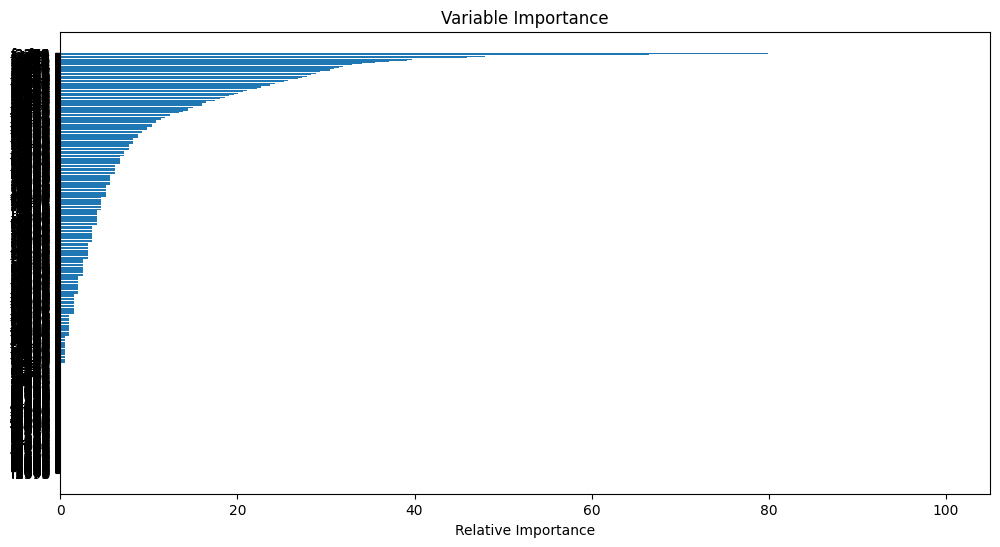

In [13]:
# feature importance
feature_importance = lgbm_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array([f'f{idx}' for idx in sorted_idx]))
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Feature: 0, Score: 63.00000
Feature: 1, Score: 92.00000
Feature: 2, Score: 58.00000
Feature: 3, Score: 106.00000
Feature: 4, Score: 48.00000
Feature: 5, Score: 29.00000
Feature: 6, Score: 77.00000
Feature: 7, Score: 47.00000
Feature: 8, Score: 89.00000
Feature: 9, Score: 59.00000
Feature: 10, Score: 44.00000
Feature: 11, Score: 138.00000
Feature: 12, Score: 60.00000
Feature: 13, Score: 57.00000
Feature: 14, Score: 129.00000
Feature: 15, Score: 58.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 62.00000
Feature: 26, Score: 52.00000
Feature: 27, Score: 61.00000
Feature: 28, Score: 37.00000
Feature: 29, Score: 43.00000
Feature: 30, Score: 35.00000
Feature: 31, Score: 188.00000
Feature: 32, Score: 92.00000
Feature: 33, Score: 34.00000
Feature: 34, Score: 20.00000


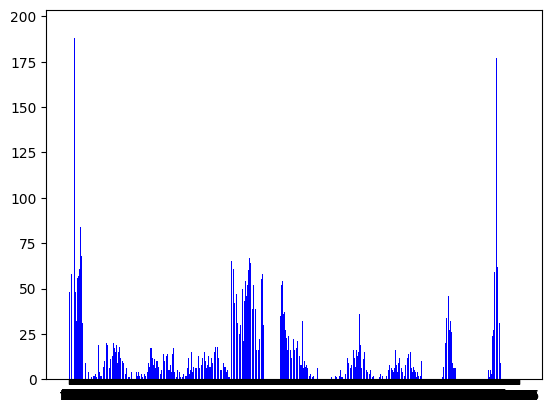

In [14]:
feature_importance = lgbm_model.feature_importances_
# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance, tick_label=[f'f{i}' for i in range(len(feature_importance))], color='blue')
plt.show()

## Best Model Metrics

Classification report
              precision    recall  f1-score   support

         bcc       0.81      0.90      0.85       498
         mel       0.89      0.90      0.89       678
         scc       0.76      0.23      0.36        94

    accuracy                           0.85      1270
   macro avg       0.82      0.68      0.70      1270
weighted avg       0.85      0.85      0.84      1270

Kaapa Val Score: 0.7192387759989683
Confusion Matrix


<Axes: >

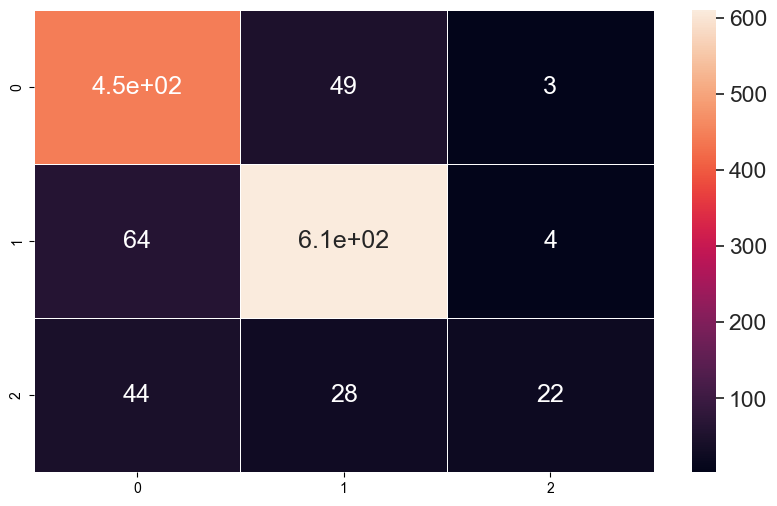

In [15]:
print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

print("Confusion Matrix")
cm = confusion_matrix(val_labels, val_prediction_transformed, labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 6))  
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [16]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = 3
target_names = ['bcc', 'mel', 'scc']

label_binarizer = LabelBinarizer().fit(y_val)
y_val_one_hot = label_binarizer.transform(y_val)
y_val_score = lgbm_model.predict_proba(x_val)

In [17]:
# compute the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_one_hot.ravel(), y_val_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# compute the macro-average ROC curve and ROC area
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_one_hot[:, i], y_val_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.93


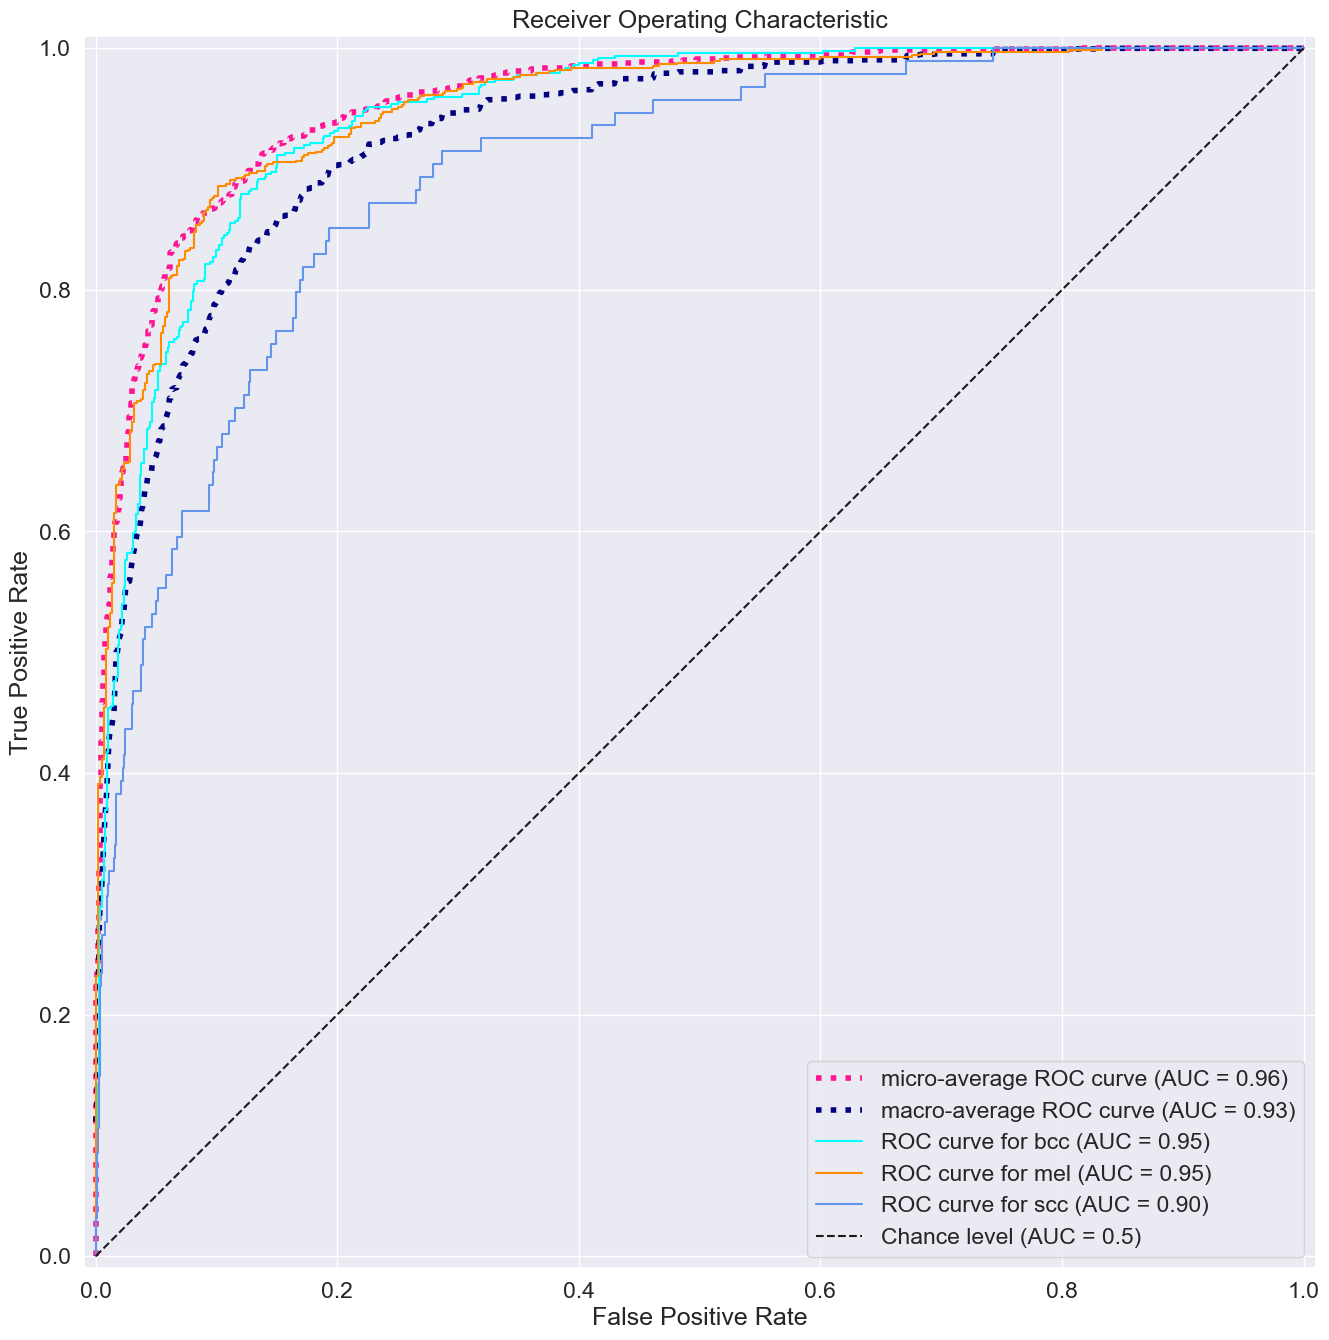

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_val_one_hot[:, class_id],
        y_val_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic",
)

## Ensemble Of Best Models

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457601
[LightGBM] [Info] Number of data points in the train set: 5082, number of used features: 1982
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy =  0.8409448818897638
Classification report
              precision    recall  f1-score   support

         bcc       0.80      0.89      0.84       498
         mel       0.88      0.90      0.89       678
         scc       0.74      0.18      0.29        94

    accuracy                           0.84      1270
   macro avg       0.81      0.66      0.67      1270
weighted avg       0.84      0.84      0.83      1270

Precision Score: 0.8369919305321399
R

<Axes: >

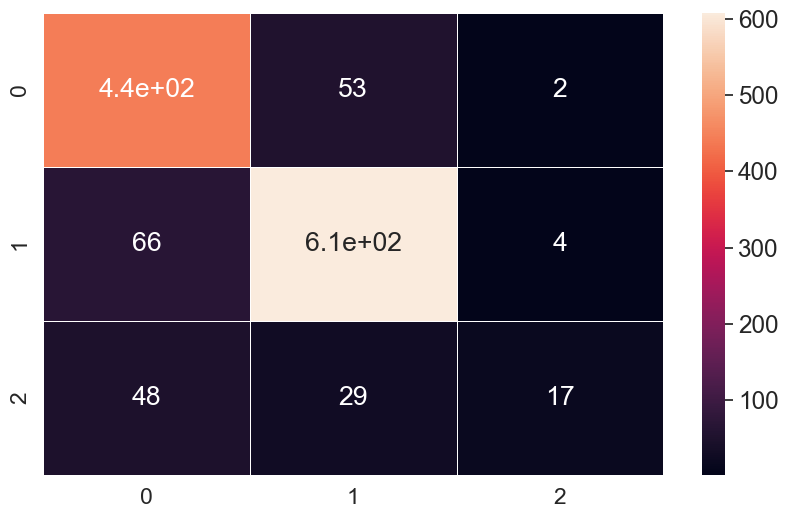

In [35]:
# make ensemble of classifiers
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, num_leaves=100, class_weight=class_weights_dict, random_state=42)
xgb_model = XGBClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight=class_weights_dict)
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42, class_weight=class_weights_dict)
catboost_model = CatBoostClassifier(depth=10, iterations=300, logging_level='Silent', random_state=42, class_weights=class_weights_dict)
ensemble_soft = VotingClassifier(estimators=[('rf', random_foreset_model), ('xgb', xgb_model), ('lgbm', lgbm_model), ('catboost', catboost_model)], voting='soft')
ensemble_soft.fit(X_train, Y_train)

# save the model
model_path = os.path.join('./', 'Ensemble_soft.pkl')
joblib.dump(ensemble_soft, model_path)

# Predict on test
val_prediction = ensemble_soft.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

print("Confusion Matrix")
# Print confusion matrix
cm = confusion_matrix(val_labels, val_prediction_transformed)
fig, ax = plt.subplots(figsize=(10, 6))  
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457601
[LightGBM] [Info] Number of data points in the train set: 5082, number of used features: 1982
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy =  0.8401574803149606
Classification report
              precision    recall  f1-score   support

         bcc       0.79      0.89      0.84       498
         mel       0.88      0.90      0.89       678
         scc       0.71      0.18      0.29        94

    accuracy                           0.84      1270
   macro avg       0.79      0.66      0.67      1270
weighted avg       0.83      0.84      0.82      1270

Precision Score: 0.8348183010319509
R

<Axes: >

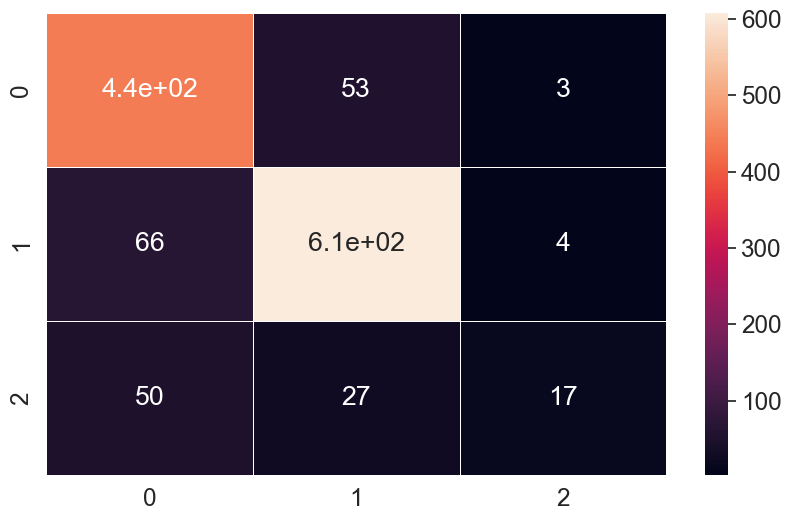

In [37]:
# make ensemble of classifiers
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, num_leaves=100, class_weight=class_weights_dict)
xgb_model = XGBClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight=class_weights_dict)
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42, class_weight=class_weights_dict)
catboost_model = CatBoostClassifier(depth=10, iterations=300, logging_level='Silent', random_state=42, class_weights=class_weights_dict)
ensemble_soft = VotingClassifier(estimators=[('rf', random_foreset_model), ('xgb', xgb_model), ('lgbm', lgbm_model)], voting='soft')
ensemble_soft.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'Ensemble_hard.pkl')
# joblib.dump(ensemble_soft, model_path)


# Predict on test
val_prediction = ensemble_soft.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))
print(f"Kaapa Val Score: {metrics.cohen_kappa_score(val_labels, val_prediction_transformed)}")

print("Confusion Matrix")
# Print confusion matrix
cm = confusion_matrix(val_labels, val_prediction_transformed)
fig, ax = plt.subplots(figsize=(10 ,6))  
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# Predictions

In [19]:
# stack X_train and X_val to train the final model
X_train_val = np.vstack((X_train, x_val))
Y_train_val = np.hstack((Y_train, y_val))

# train the final model
lgbm_model_f = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, num_leaves=100, class_weight=class_weights_dict, verbose=-1)
lgbm_model_f.fit(X_train, Y_train)

# save the model
model_path = os.path.join('./', 'Final_lgbm_model.pkl')
joblib.dump(lgbm_model_f, model_path)

['./Final_lgbm_model.pkl']

In [20]:
TEST_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/3_class_testX', "*.jpg")))
print(f"Number of test images: {len(TEST_IMAGES_PATH)}")

Number of test images: 2121


In [4]:
# compute the test features
color_moments_test_features = []
color_histogram_test_features = []
lbp_test_image_features = []
glcm_test_image_features = []

for image_path in TEST_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hair_removed = hair_removal(image)
    cropped_image = crop_img(hair_removed)
    norm_image = normalize_colors_shades_of_gray(cropped_image)
    image = cv2.resize(norm_image, (500, 500), interpolation=cv2.INTER_CUBIC)

    
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_test_features.append(moments)
    color_histogram_test_features.append(histogram)
        
        
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp_5_8 = lbp_feature_extractor(image_gray, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image_gray, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image_gray, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image_gray, radius=10, points=16)
    glcm = glcm_feature_extractor(image_gray)
    
    lbp_test_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_test_image_features.append(glcm)

lbp_test_image_features = np.array(lbp_test_image_features)
glcm_test_image_features = np.array(glcm_test_image_features).reshape((2121, 25))   
color_moments_test_features = np.array(color_moments_test_features).reshape((2121, 12))
color_histogram_test_features = np.array(color_histogram_test_features).reshape((2121, 2304))

# Combine all features
all_test_features = np.hstack((glcm_test_image_features, lbp_test_image_features, color_moments_test_features, color_histogram_test_features))

# save all features
np.save('../../dataset/3_class_testX/all_test_features.npy', all_test_features)

In [22]:
# load all features
all_test_features = np.load('../../dataset/3_class_testX/all_test_features.npy')
# Make predictions
predictions = lgbm_model_f.predict(all_test_features)
output_file = 'ML_multi_preds.txt'

# Save predictions to a text file
with open(output_file, 'w') as f:
    for i, pred in enumerate(predictions):
        f.write(f"{os.path.basename(TEST_IMAGES_PATH[i])}: {pred}\n")

print(f"Predictions saved to {output_file}")


Predictions saved to ML_multi_preds_sub.txt


In [2]:
import pandas as pd

# Load the text file
file_path = r"ML_multi_preds.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the lines into a DataFrame
data = []
for line in lines:
    img_name, label = line.strip().split(': ')
    data.append((img_name, int(label)))

# Convert to DataFrame and save as CSV
df = pd.DataFrame(data, columns=['Image', 'Prediction'])
# replace the label 0 with 1 and 1 with 0
df['Prediction'] = df['Prediction'].replace({0: 1, 1: 0})
csv_path = "ML_multi_preds_corrected.csv"
df.to_csv(csv_path, index=False)

csv_path


'ML_multi_preds_corrected.csv'

In [4]:
# turn a txt to a csv file
txt_file = r"ML_multi_preds.txt"
csv_file = r"ML_multi_preds.csv"

in_txt = csv.reader(open(txt_file, "r"), delimiter = '\n')
out_csv = csv.writer(open(csv_file, 'w'))
